A ideia básica é treinar um classificador utilizando cross-validation 5-folds. Vou realizar o corte em folds no .csv e dentro do loop utilizar dataloaders.

In [1]:
import torch
import pandas as pd
import os
import imageio as im
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,utils
import torchvision
import numpy as np
import time
import copy
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.model_selection import KFold

In [2]:
import sys

sys.path.append('/store/vrusso/skin-tone-research/tools')
for p in sys.path:
    print( p )
    
from fitzpatrick17k import FitzpatrickDataset

/store/vrusso/skin-tone-research/simple_cnn_classifier
/opt/conda/lib/python38.zip
/opt/conda/lib/python3.8
/opt/conda/lib/python3.8/lib-dynload

/opt/conda/lib/python3.8/site-packages
/store/vrusso/skin-tone-research/tools


In [3]:
df = pd.read_csv('../../datasets/fitzpatrick17k/fitzpatrick17k.csv')

df

,md5hash,fitzpatrick,label,nine_partition_label,three_partition_label,url,url_alphanum
0,dae2d6176ea28b4d991c573c8320b0cf,4,lichen planus,inflammatory,non-neoplastic,http://atlasdermatologico.com.br/img?imageId=3739,httpwwwatlasdermatologicocombrimgimageId3739.jpg
1,dcba3efe0fe28be2b0032df9470c320d,5,behcets disease,inflammatory,non-neoplastic,http://atlasdermatologico.com.br/img?imageId=8633,httpwwwatlasdermatologicocombrimgimageId8633.jpg
2,9a9ded2de5e2c20a90cdfc2971e2e155,2,pityriasis lichenoides chronica,inflammatory,non-neoplastic,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppityr...
3,d6166c9947e7e99915ff4d6907ddec44,2,mycosis fungoides,malignant cutaneous lymphoma,malignant,http://atlasdermatologico.com.br/img?imageId=4594,httpwwwatlasdermatologicocombrimgimageId4594.jpg
4,8ea58508e89d61a98320acb03139b8bb,3,urticaria pigmentosa,inflammatory,non-neoplastic,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicuurtic...
...,...,...,...,...,...,...,...
16520,54aa2f1bf36b27de991db5cd358bde06,2,squamous cell carcinoma,malignant epidermal,malignant,http://atlasdermatologico.com.br/img?imageId=6834,httpwwwatlasdermatologicocombrimgimageId6834.jpg
16521,b3ce9d9d122db072fdf3245521263c06,2,erythema multiforme,inflammatory,non-neoplastic,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpiceeryth...
16522,6fcaf3c1ecef5a938bf70ae2b6ed24f6,2,basal cell carcinoma,malignant epidermal,malignant,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicbbasal...
16523,b0b5f5950d2fda0eed8304ea18eef430,4,actinic keratosis,malignant epidermal,malignant,http://atlasdermatologico.com.br/img?imageId=3067,httpwwwatlasdermatologicocombrimgimageId3067.jpg


In [4]:
print("Número de instâncias com -1 no label:"+str(len(df[df['fitzpatrick']== -1])))
print("Dropando estas instâncias...")
df = df.drop(df[df['fitzpatrick']== -1].index,axis=0)
df.head()

Número de instâncias com -1 no label:559
Dropando estas instâncias...


,md5hash,fitzpatrick,label,nine_partition_label,three_partition_label,url,url_alphanum
0,dae2d6176ea28b4d991c573c8320b0cf,4,lichen planus,inflammatory,non-neoplastic,http://atlasdermatologico.com.br/img?imageId=3739,httpwwwatlasdermatologicocombrimgimageId3739.jpg
1,dcba3efe0fe28be2b0032df9470c320d,5,behcets disease,inflammatory,non-neoplastic,http://atlasdermatologico.com.br/img?imageId=8633,httpwwwatlasdermatologicocombrimgimageId8633.jpg
2,9a9ded2de5e2c20a90cdfc2971e2e155,2,pityriasis lichenoides chronica,inflammatory,non-neoplastic,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppityr...
3,d6166c9947e7e99915ff4d6907ddec44,2,mycosis fungoides,malignant cutaneous lymphoma,malignant,http://atlasdermatologico.com.br/img?imageId=4594,httpwwwatlasdermatologicocombrimgimageId4594.jpg
4,8ea58508e89d61a98320acb03139b8bb,3,urticaria pigmentosa,inflammatory,non-neoplastic,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicuurtic...


In [5]:
len(df)

15966

In [6]:
kf = KFold(n_splits=5, shuffle=True, random_state=19 )
kf

KFold(n_splits=5, random_state=19, shuffle=True)

In [7]:
import pytorch_lightning as pl

In [8]:
n_classes = 6
import torch.nn.functional as F

class LitClassificationModel(pl.LightningModule):
    
    def __init__(self, df_train, df_test):
        super().__init__()
        self.df_train = df_train
        self.df_test = df_test
        self.train_loss_history = []
        self.train_acc_history = []
        self.train_acc_relaxed_history = []
        
        self.test_loss_history = []
        self.test_acc_history = []
        self.test_acc_relaxed_history = []
        self.model = models.resnet50(pretrained=True)
        num_features_in_fc = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features_in_fc, n_classes)
        for param in self.model.parameters():
            param.requires_grad = True
            
    def forward(self,x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.1)
        return [optimizer],[exp_lr_scheduler]
    
    def training_step(self,batch,batch_idx):
        inputs = batch['image']
        labels = batch['label']
        outputs = self(inputs)
        
        _, preds = torch.max(outputs,1)
        labels = torch.argmax(labels,axis=1)
        
        
        loss = F.cross_entropy(outputs,labels.long())
        running_corrects = torch.sum(preds == labels)
        
        relaxed_running_hits = torch.sum(preds == labels) + torch.sum(preds == labels+1)+torch.sum(preds == labels-1)
        
        return {'loss':loss, 'hits':running_corrects,'relaxed_hits':relaxed_running_hits}
    
    def training_epoch_end(self,outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        num_hits = torch.stack([x['hits'] for x in outputs]).sum()
        relaxed_hits = torch.stack([x['relaxed_hits'] for x in outputs]).sum()
        self.train_loss_history.append(avg_loss.item())
        self.train_acc_history.append(num_hits.item())
        self.train_acc_relaxed_history.append(relaxed_hits.item())
        return None
    
    def validation_step(self,batch,batch_idx):
        inputs = batch['image']
        labels = batch['label']
        outputs = self(inputs)
        
        _, preds = torch.max(outputs,1)
        labels = torch.argmax(labels,axis=1)
        loss = F.cross_entropy(outputs,labels.long())
        running_corrects = torch.sum(preds == labels)
        
        relaxed_running_hits = torch.sum(preds == labels) + torch.sum(preds == labels+1)+torch.sum(preds == labels-1)
        
        return {'loss':loss, 'hits':running_corrects,'relaxed_hits':relaxed_running_hits}
    
    def validation_epoch_end(self,outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        num_hits = torch.stack([x['hits'] for x in outputs]).sum()
        relaxed_hits = torch.stack([x['relaxed_hits'] for x in outputs]).sum()
        self.test_loss_history.append(avg_loss.item())
        self.test_acc_history.append(num_hits.item())
        self.test_acc_relaxed_history.append(relaxed_hits.item())
        
        print(relaxed_hits)
        return None
    
    def train_dataloader(self):
        data_train = FitzpatrickDataset( self.df_train,'../../datasets/fitzpatrick17k/resized_images', target = 'fitzpatrick',
                          transform = transforms.Compose([transforms.ToTensor(),
                                                          transforms.RandomResizedCrop(224),
                                                          transforms.RandomHorizontalFlip(),
                                                          transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]))
    
        train_dataloader = DataLoader(data_train,batch_size=64,num_workers=8,shuffle=True)
        
        return train_dataloader
    
    def val_dataloader(self):
        data_val = FitzpatrickDataset( self.df_test,'../../datasets/fitzpatrick17k/resized_images', target = 'fitzpatrick',
                          transform = transforms.Compose([transforms.ToTensor(),
                                                          transforms.CenterCrop(224),
                                                          transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]))
    
        val_dataloader = DataLoader(data_val,batch_size=64,num_workers=8,shuffle=False)
    
        return val_dataloader

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23.5 M
---------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.081    Total estimated model params size (MB)


tensor(43, device='cuda:0')


tensor(2819, device='cuda:0')


tensor(2872, device='cuda:0')


tensor(2876, device='cuda:0')


tensor(2888, device='cuda:0')


tensor(2881, device='cuda:0')

[10478, 11185, 11261, 11222, 11273]
[5039, 5860, 5989, 6018, 6059]


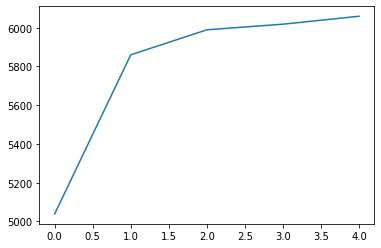

In [9]:
from pytorch_lightning import Trainer

for train_index, test_index in kf.split(df):
    df_train = df.iloc[train_index]
    df_test = df.iloc[test_index]
    
    
    model = LitClassificationModel(df_train,df_test)
    
    #trainer = Trainer(fast_dev_run=True)
    trainer = Trainer(max_epochs=5,accelerator='gpu',gpus=1)
    
    
    trainer.fit(model)
    print(model.train_acc_relaxed_history)
    print(model.train_acc_history)
    plt.plot(model.train_acc_history)
    break
    
    
    

[21, 1462, 1517, 1514, 1525, 1514]


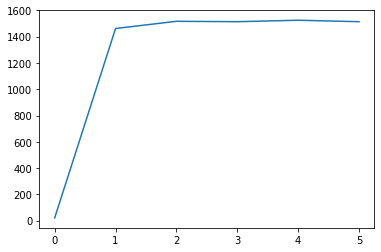

In [10]:
print(model.test_acc_history)
plt.plot(model.test_acc_history)

[43, 2819, 2872, 2876, 2888, 2881]


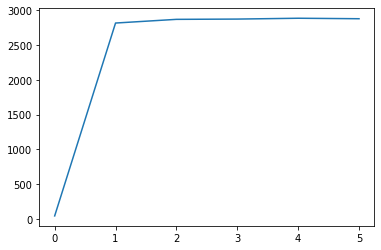

In [11]:
print(model.test_acc_relaxed_history)
plt.plot(model.test_acc_relaxed_history)

In [12]:
len(df_test)

3194